<a href="https://colab.research.google.com/github/kkokosa/memoryexpert-course/blob/main/GC_Modes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments

                     label     Average  50th Percentile  90th Percentile  95th Percentile
0         addproducttocart  197.217165            185.0            257.2           290.20
1                  awesome  202.432990            189.0            301.0           336.25
2  build-your-own-computer  162.347601            160.0            240.0           265.50
3                     cart  570.087811            557.0            806.8           878.90
4                computers   78.858612             75.0            104.0           112.00
5                 homepage  182.519182            171.0            250.0           269.00
6        product-details/1   24.608301             22.0             35.0            40.00
7        product-details/2   24.771429             21.0             36.0            46.00
8           removefromcart  599.336399            587.0            831.0           901.00


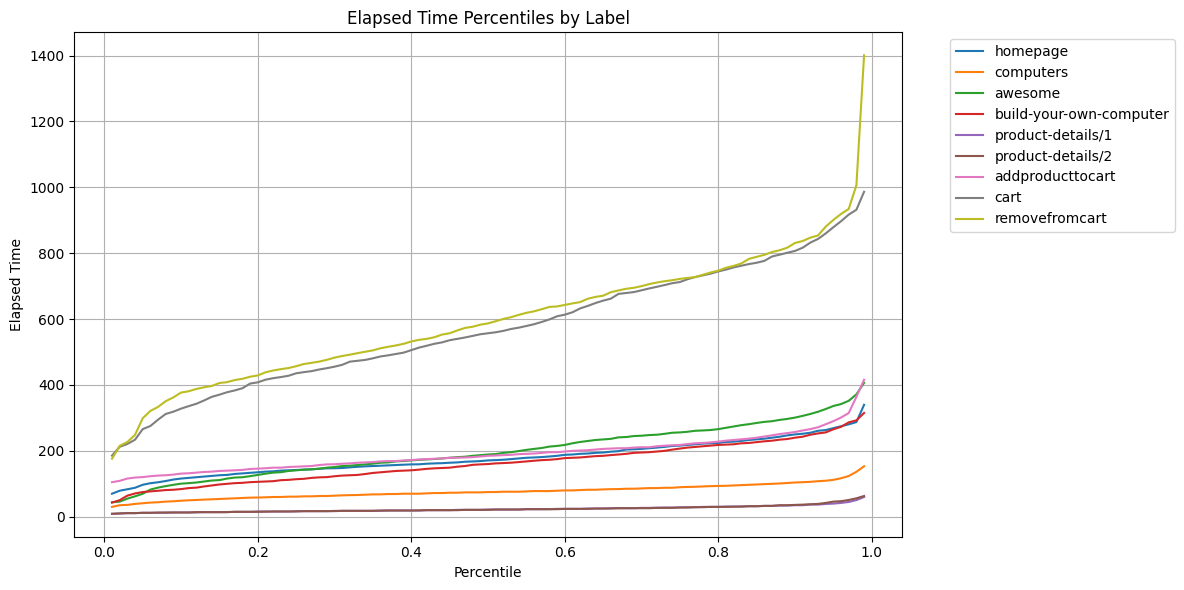

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set display options to show all columns without wrapping
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/benchmarks/nop_jmeter_server_concurrent.csv')

# Group by label and calculate percentiles
result = df.groupby('label')['elapsed'].agg([
    ('Average', 'mean'),
    ('50th Percentile', lambda x: x.quantile(0.5)),
    ('90th Percentile', lambda x: x.quantile(0.9)),
    ('95th Percentile', lambda x: x.quantile(0.95))
]).reset_index()

# Display the result
print(result)

# Optionally, save the result to a new CSV file
# result.to_csv('result.csv', index=False)
# files.download('result.csv')

### Create a box plot

# Create percentile range
percentiles = np.arange(0.01, 1.00, 0.01)

# Calculate percentiles for each label
percentile_data = {}
for label in df['label'].unique():
    label_data = df[df['label'] == label]['elapsed']
    percentile_data[label] = np.percentile(label_data, percentiles * 100)

# Create the plot
plt.figure(figsize=(12, 6))

for label, data in percentile_data.items():
    plt.plot(percentiles, data, label=label)

plt.xlabel('Percentile')
plt.ylabel('Elapsed Time')
plt.title('Elapsed Time Percentiles by Label')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# Counters

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_counter_data(directory, counter_name):
    def process_file(filepath):
        df = pd.read_csv(filepath)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        counter_data = df[df['Counter Name'] == counter_name]
        counter_data = counter_data.sort_values('Timestamp')

        counter_data['Relative Time'] = (counter_data['Timestamp'] - counter_data['Timestamp'].min()).dt.total_seconds()

        filename = os.path.basename(filepath)
        series_name = filename.replace('nop_counters_', '').replace('.csv', '')

        return counter_data[['Relative Time', 'Mean/Increment']], series_name

    processed_data = []
    for filename in os.listdir(directory):
        if 'nop_counters_' in filename and filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            processed_data.append(process_file(filepath))

    plt.figure(figsize=(12, 6))

    for data, series_name in processed_data:
        plt.plot(data['Relative Time'], data['Mean/Increment'], label=series_name)

    plt.xlabel('Time (seconds)')
    plt.ylabel(counter_name)
    plt.title(f'{counter_name} Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

def plot_counter_bar_with_stats(directory, counter_name):
    def process_file(filepath):
        df = pd.read_csv(filepath)
        counter_data = df[df['Counter Name'] == counter_name]

        filename = os.path.basename(filepath)
        series_name = filename.replace('nop_counters_', '').replace('.csv', '')

        return {
            'name': series_name,
            'min': counter_data['Mean/Increment'].min(),
            'max': counter_data['Mean/Increment'].max(),
            'mean': counter_data['Mean/Increment'].mean()
        }

    processed_data = []
    for filename in os.listdir(directory):
        if 'nop_counters_' in filename and filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            processed_data.append(process_file(filepath))

    fig, ax = plt.subplots(figsize=(8, 6))

    names = [data['name'] for data in processed_data]
    mins = [data['min'] for data in processed_data]
    maxs = [data['max'] for data in processed_data]
    means = [data['mean'] for data in processed_data]

    x = np.arange(len(names))
    width = 0.8

    # Book-friendly grayscale color scheme
    grays = ['#FFFFFF', '#CCCCCC', '#999999', '#666666', '#333333']
    patterns = ['', '//', '\\\\', 'xx', '..']

    unique_series = names
    series_style = {series: (grays[i % len(grays)], patterns[i % len(patterns)])
                    for i, series in enumerate(unique_series)}

    for i, (name, min_val, max_val, mean_val) in enumerate(zip(names, mins, maxs, means)):
        color, hatch = series_style[name]
        ax.bar(i, max_val - min_val, width, bottom=min_val, color=color,
               edgecolor='black', hatch=hatch, linewidth=1)
        ax.plot([i-width/2, i+width/2], [mean_val, mean_val], color='black', linewidth=4)

    ax.set_ylabel(counter_name)
    ax.set_title(f'{counter_name} Statistics')
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right')

    custom_patches = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='black', hatch=hatch)
                      for color, hatch in series_style.values()]
    custom_patches.append(Line2D([0], [0], color='black', lw=2))
    ax.legend(custom_patches, unique_series + ['Mean'], loc='upper left', bbox_to_anchor=(1, 1))

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

directory = '/content/drive/MyDrive/Colab Notebooks/benchmarks'

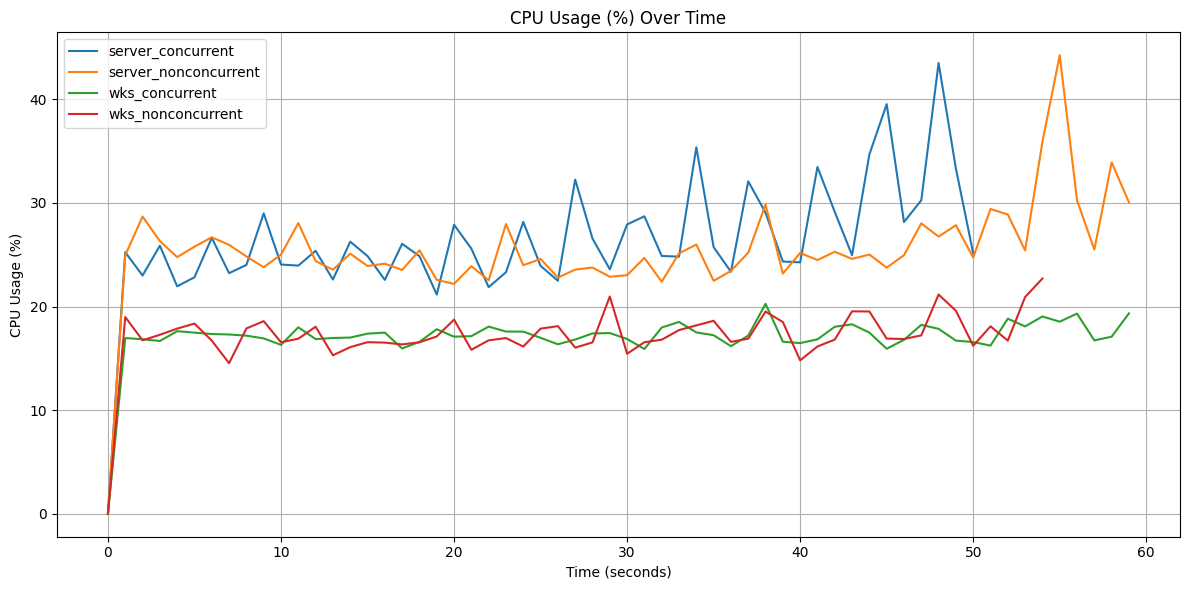

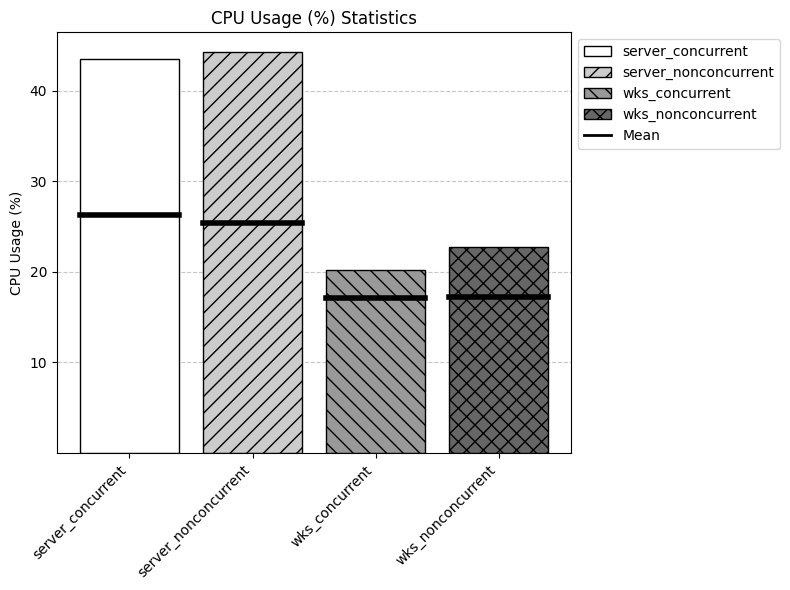

In [148]:
plot_counter_data(directory, "CPU Usage (%)")
plot_counter_bar_with_stats(directory, "CPU Usage (%)")

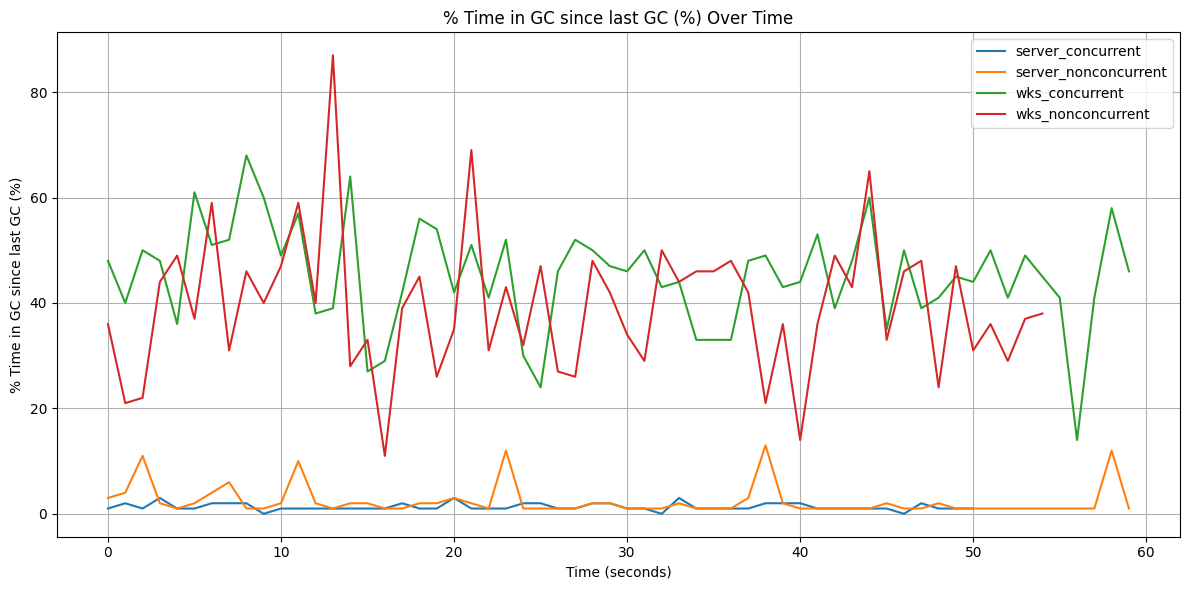

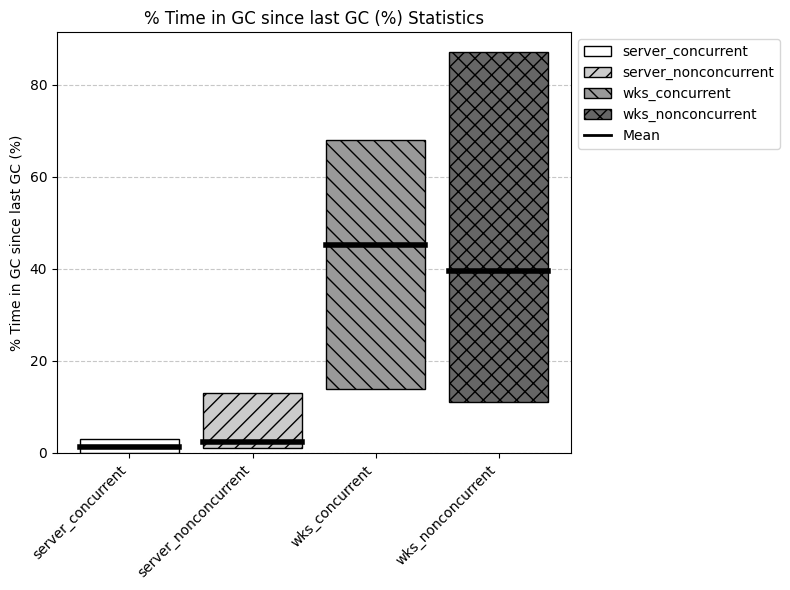

In [149]:
plot_counter_data(directory, "% Time in GC since last GC (%)")
plot_counter_bar_with_stats(directory, "% Time in GC since last GC (%)")

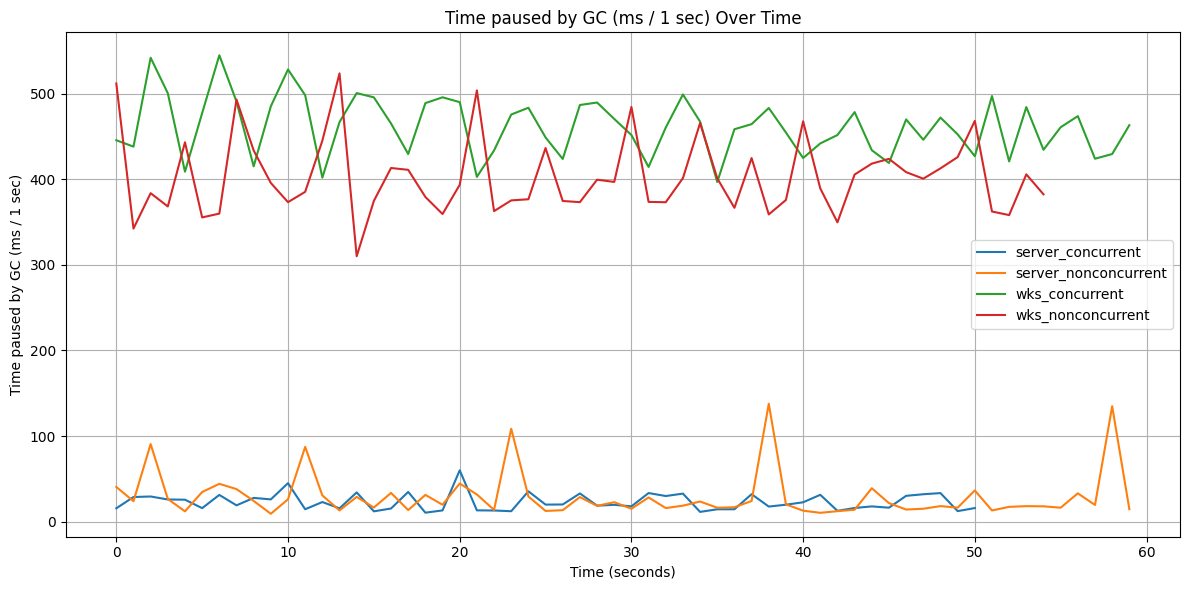

In [119]:
plot_counter_data(directory, "Time paused by GC (ms / 1 sec)")

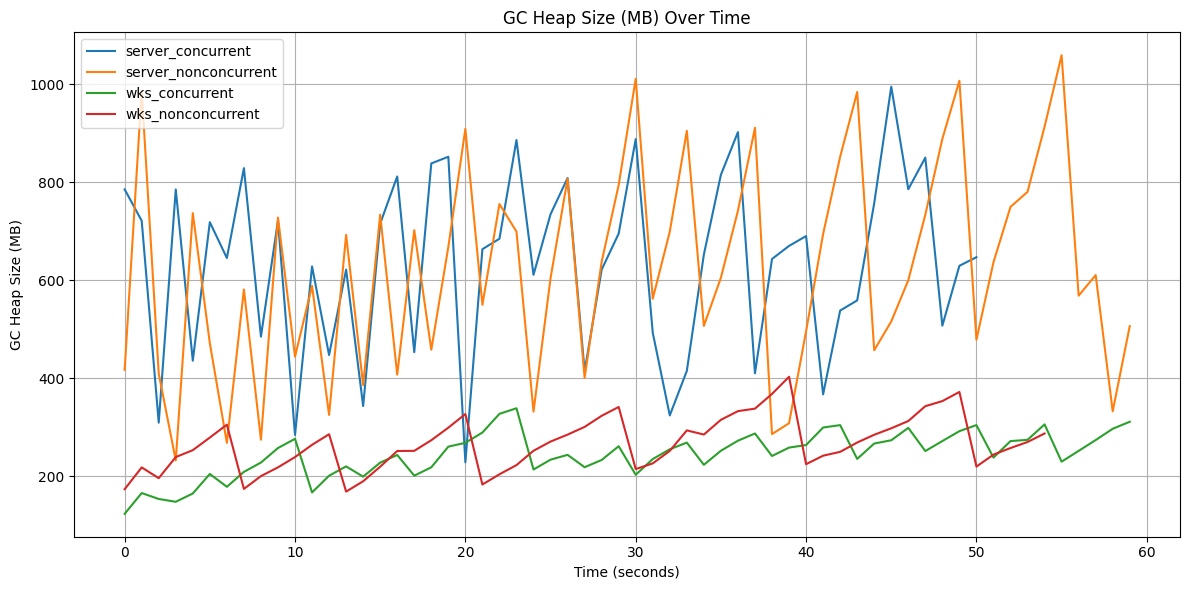

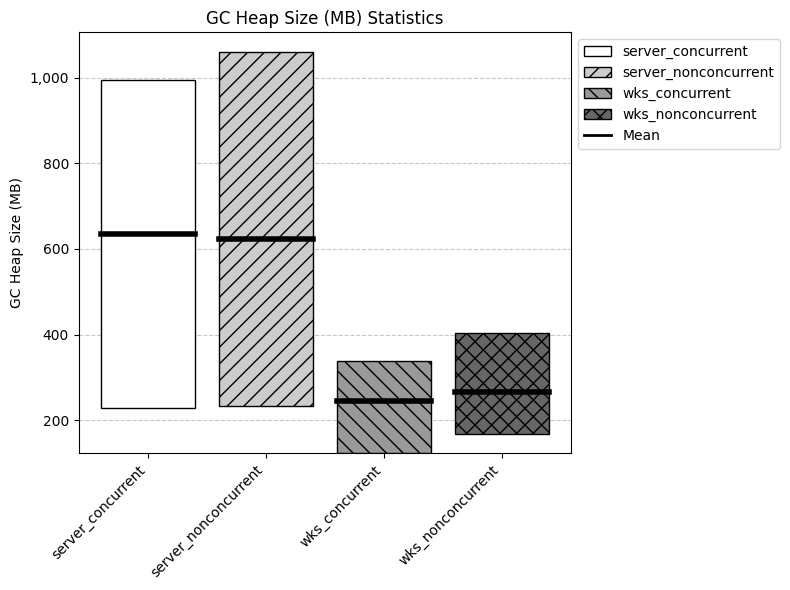

In [150]:
plot_counter_data(directory, "GC Heap Size (MB)")
plot_counter_bar_with_stats(directory, "GC Heap Size (MB)")

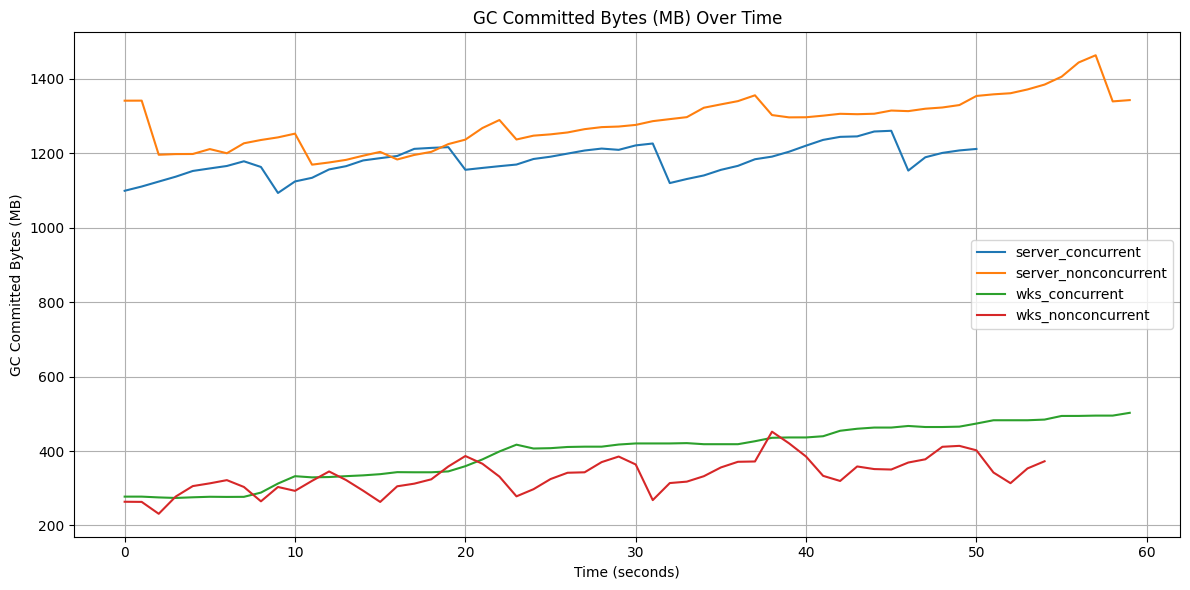

In [121]:
plot_counter_data(directory, "GC Committed Bytes (MB)")

# Trace

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import itertools
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

def plot_gc_stats(directory, column_to_plot, group_by=None):
   def process_file(filepath):
       df = pd.read_csv(filepath)
       filename = os.path.basename(filepath)
       series_name = filename.replace('nop_trace_', '').replace('.csv', '')

       df['Relative PauseStart'] = df['PauseStart'] - df['PauseStart'].min()

       return df, series_name

   processed_data = []
   for filename in os.listdir(directory):
       if filename.startswith('nop_trace_') and filename.endswith('.csv'):
           filepath = os.path.join(directory, filename)
           processed_data.append(process_file(filepath))

   fig, ax = plt.subplots(figsize=(12, 6))

   markers = itertools.cycle(['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'H', '+', 'x'])
   color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

   for i, (df, series_name) in enumerate(processed_data):
       color = color_cycle[i % len(color_cycle)]
       if group_by:
           grouped = df.groupby(group_by)
           for name, group in grouped:
               marker = next(markers)
               ax.plot(group['Relative PauseStart'], group[column_to_plot],
                       label=f'{series_name} - {name}',
                       marker=marker, color=color, linestyle='-', markersize=6)
       else:
           ax.plot(df['Relative PauseStart'], df[column_to_plot],
                   label=series_name, marker='o', color=color, linestyle='-', markersize=6)

   ax.set_xlabel('Relative Pause Start Time (ms)')
   ax.set_ylabel(column_to_plot)
   ax.set_title(f'{column_to_plot} over GC Collections')
   ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   plt.grid(True)
   plt.tight_layout()
   plt.show()

def plot_gc_stats_bar_with_stats(directory, column_to_plot, group_by=None):
    def process_file(filepath):
        df = pd.read_csv(filepath)
        filename = os.path.basename(filepath)
        series_name = filename.replace('nop_trace_', '').replace('.csv', '')
        return df, series_name

    processed_data = []
    for filename in os.listdir(directory):
        if filename.startswith('nop_trace_') and filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            processed_data.append(process_file(filepath))

    fig, ax = plt.subplots(figsize=(10, 6))

    if group_by:
        grouped_data = []
        for df, series_name in processed_data:
            grouped = df.groupby(group_by)[column_to_plot]
            stats = grouped.agg(['min', 'mean', 'max'])
            for group, row in stats.iterrows():
                grouped_data.append((series_name, group, row['min'], row['mean'], row['max']))
    else:
        grouped_data = [(name, '', df[column_to_plot].min(), df[column_to_plot].mean(), df[column_to_plot].max())
                        for df, name in processed_data]

    x = np.arange(len(grouped_data))
    width = 0.8

    # Book-friendly grayscale color scheme
    grays = ['#FFFFFF', '#CCCCCC', '#999999', '#666666', '#333333']
    patterns = ['', '//', '\\\\', 'xx', '..']

    unique_series = list(set(data[0] for data in grouped_data))
    series_style = {series: (grays[i % len(grays)], patterns[i % len(patterns)])
                    for i, series in enumerate(unique_series)}

    for i, (series, group, min_val, mean_val, max_val) in enumerate(grouped_data):
        color, hatch = series_style[series]
        ax.bar(i, max_val - min_val, width, bottom=min_val, color=color,
               edgecolor='black', hatch=hatch, linewidth=1)
        ax.plot([i-width/2, i+width/2], [mean_val, mean_val], color='black', linewidth=4)

    ax.set_ylabel(column_to_plot)
    ax.set_title(f'{column_to_plot} Statistics')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{data[0]}-{data[1]}" if data[1] else data[0] for data in grouped_data], rotation=45, ha='right')

    custom_patches = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='black', hatch=hatch)
                      for color, hatch in series_style.values()]
    custom_patches.append(Line2D([0], [0], color='black', lw=2))
    ax.legend(custom_patches, unique_series + ['Mean'], loc='upper left', bbox_to_anchor=(1, 1))

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_gc_stats_percentiles(directory, column_to_plot='PauseMSec'):
    def process_file(filepath):
        df = pd.read_csv(filepath)
        filename = os.path.basename(filepath)
        series_name = filename.replace('nop_trace_', '').replace('.csv', '')
        return df, series_name

    processed_data = []
    for filename in os.listdir(directory):
        if filename.startswith('nop_trace_') and filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            processed_data.append(process_file(filepath))

    fig, ax = plt.subplots(figsize=(12, 6))

    # Book-friendly grayscale style
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    grays = ['#000000', '#333333', '#666666', '#999999', '#CCCCCC']

    for i, (df, series_name) in enumerate(processed_data):
        percentiles = 1 - 10**np.linspace(-4, -1, 100)
        values = np.percentile(df[column_to_plot], percentiles * 100)

        line_style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        color = grays[i % len(grays)]

        ax.semilogx(1 - percentiles, values, label=series_name,
                    linestyle=line_style, marker=marker, markevery=10,
                    color=color, base=10, markersize=6)

    ax.set_xlim(1e-4, 1e-1)
    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{(1-x):,.2%}'))
    ax.set_xlabel('Percentile')
    ax.set_ylabel(column_to_plot)
    ax.set_title(f'{column_to_plot} Percentiles')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

def plot_gc_histogram(directory):
    def process_file(filepath):
        df = pd.read_csv(filepath)
        filename = os.path.basename(filepath)
        series_name = filename.replace('nop_trace_', '').replace('.csv', '')
        return df, series_name

    processed_data = []
    for filename in os.listdir(directory):
        if filename.startswith('nop_trace_') and filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            processed_data.append(process_file(filepath))

    fig, ax = plt.subplots(figsize=(12, 6))

    grouped_data = []
    all_generations = set()
    for df, series_name in processed_data:
        grouped = df['Gen'].value_counts()
        grouped_data.append((series_name, grouped))
        all_generations.update(grouped.index)

    all_generations = sorted(all_generations)
    x = np.arange(len(all_generations))
    width = 0.8 / len(processed_data)

    # Book-friendly grayscale color scheme
    grays = ['#FFFFFF', '#CCCCCC', '#999999', '#666666', '#333333']
    patterns = ['', '//', '\\\\', 'xx', '..']

    for i, (series_name, data) in enumerate(grouped_data):
        color = grays[i % len(grays)]
        hatch = patterns[i % len(patterns)]
        values = [data.get(gen, 0) for gen in all_generations]
        ax.bar(x + i*width, values, width, label=series_name,
               color=color, edgecolor='black', hatch=hatch, linewidth=1)

    ax.set_ylabel('Number of GC occurrences')
    ax.set_title('GC Occurrences by Generation')
    ax.set_xticks(x + width * (len(processed_data) - 1) / 2)
    ax.set_xticklabels(all_generations)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

directory = '/content/drive/MyDrive/Colab Notebooks/benchmarks'

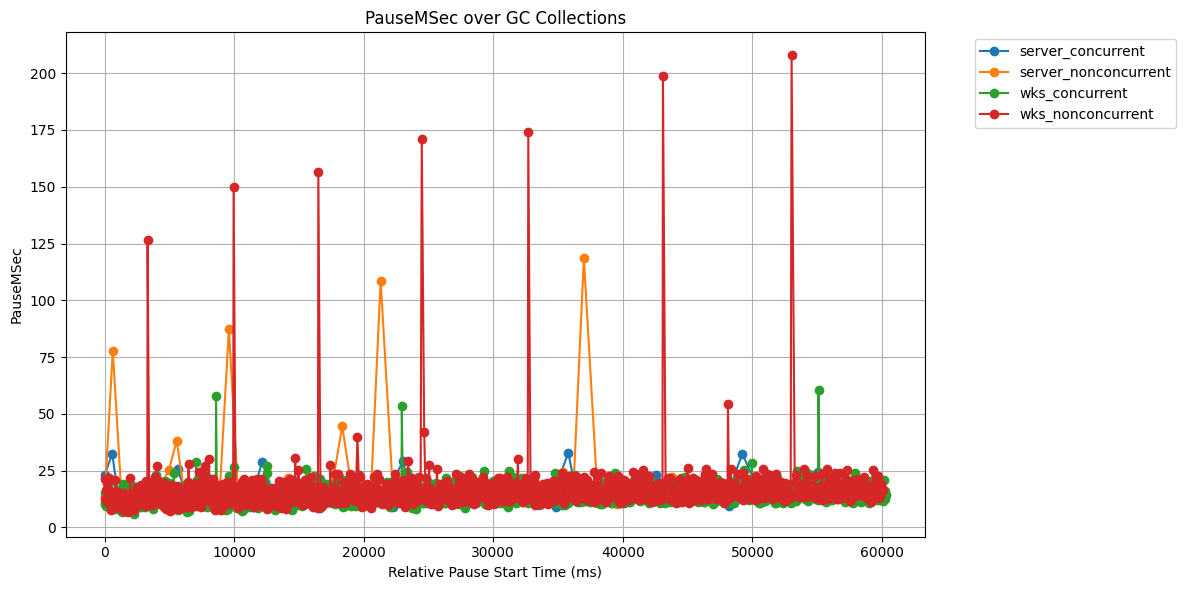

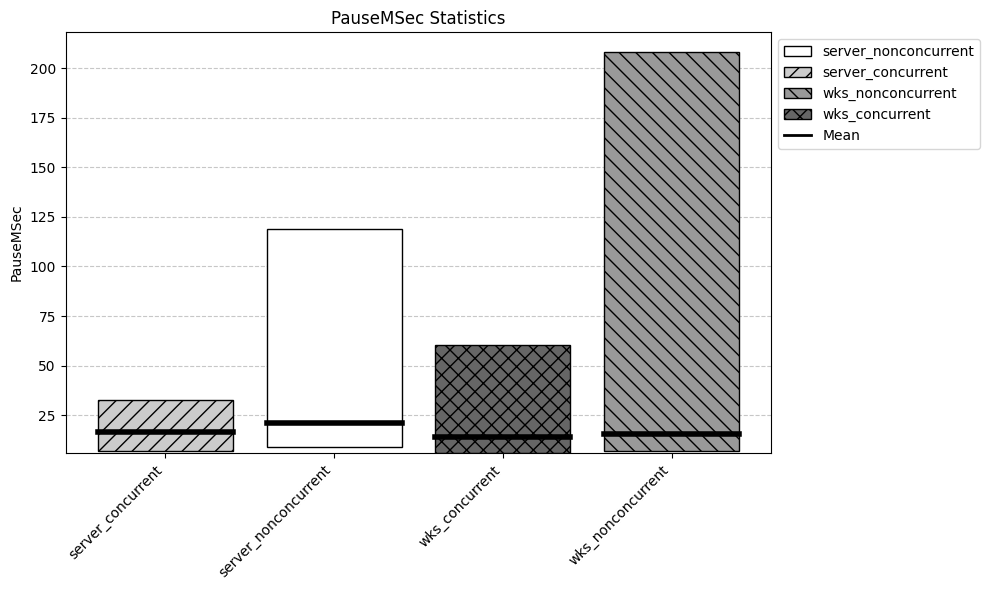

In [152]:
plot_gc_stats(directory, 'PauseMSec')
plot_gc_stats_bar_with_stats(directory, 'PauseMSec')

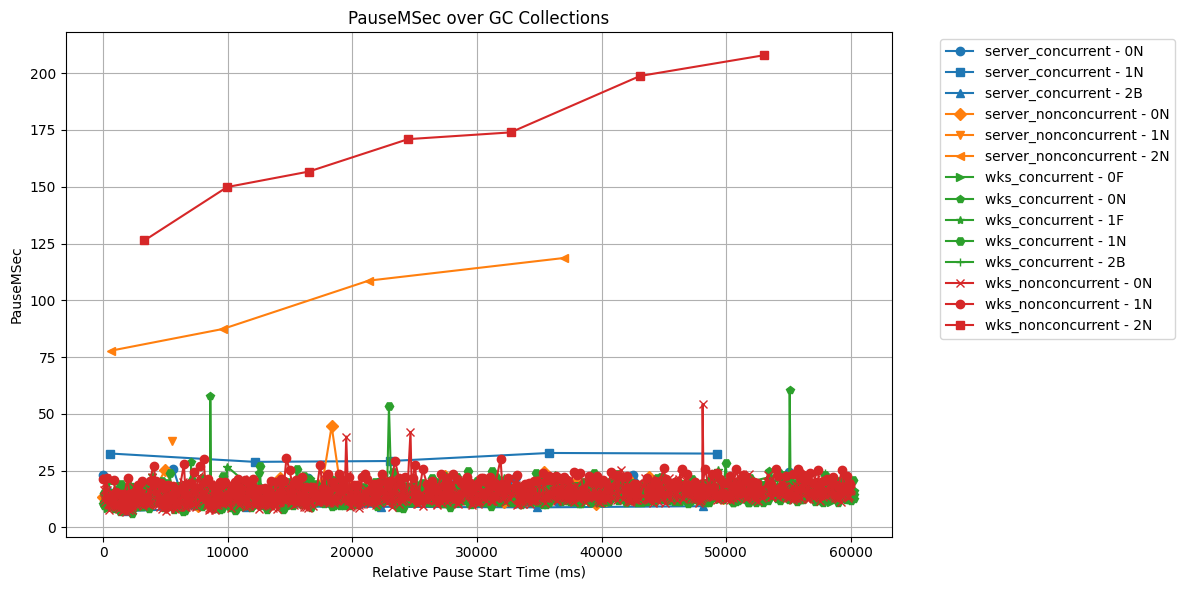

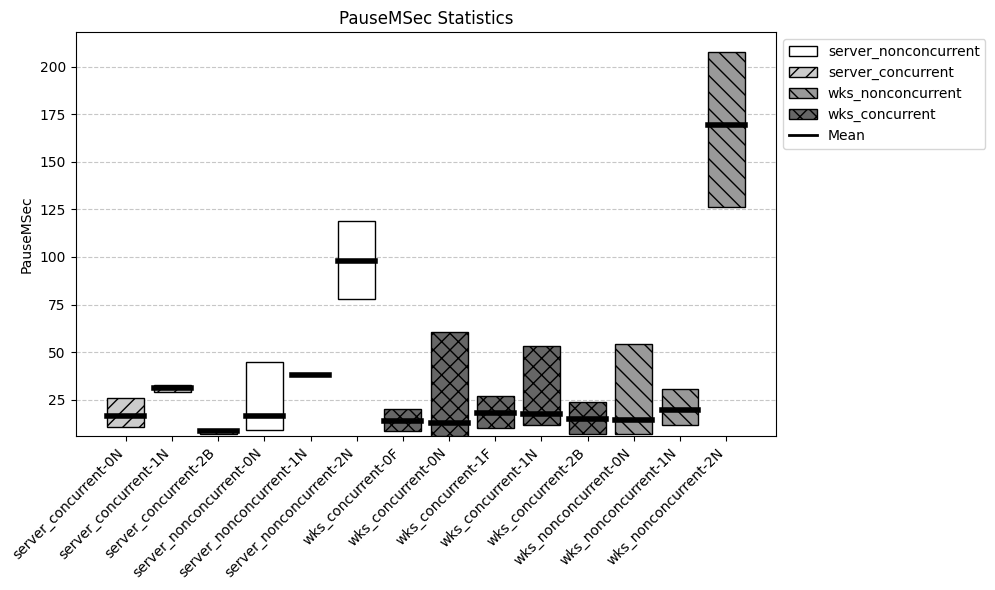

In [153]:
plot_gc_stats(directory, 'PauseMSec', group_by='Gen')
plot_gc_stats_bar_with_stats(directory, 'PauseMSec', group_by='Gen')

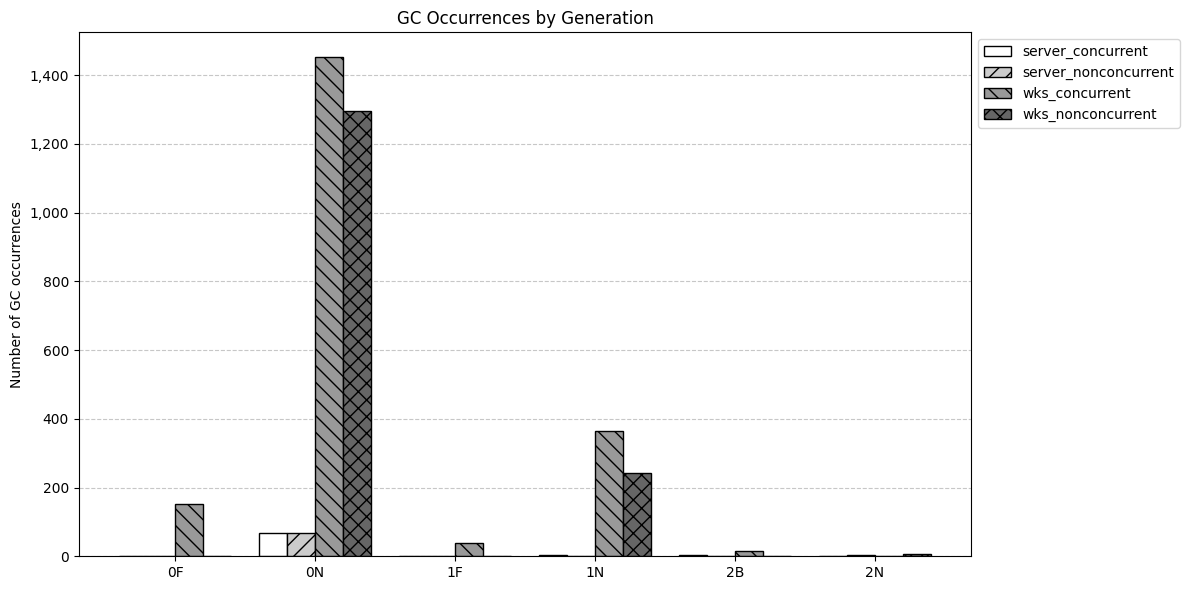

In [154]:
plot_gc_histogram(directory)

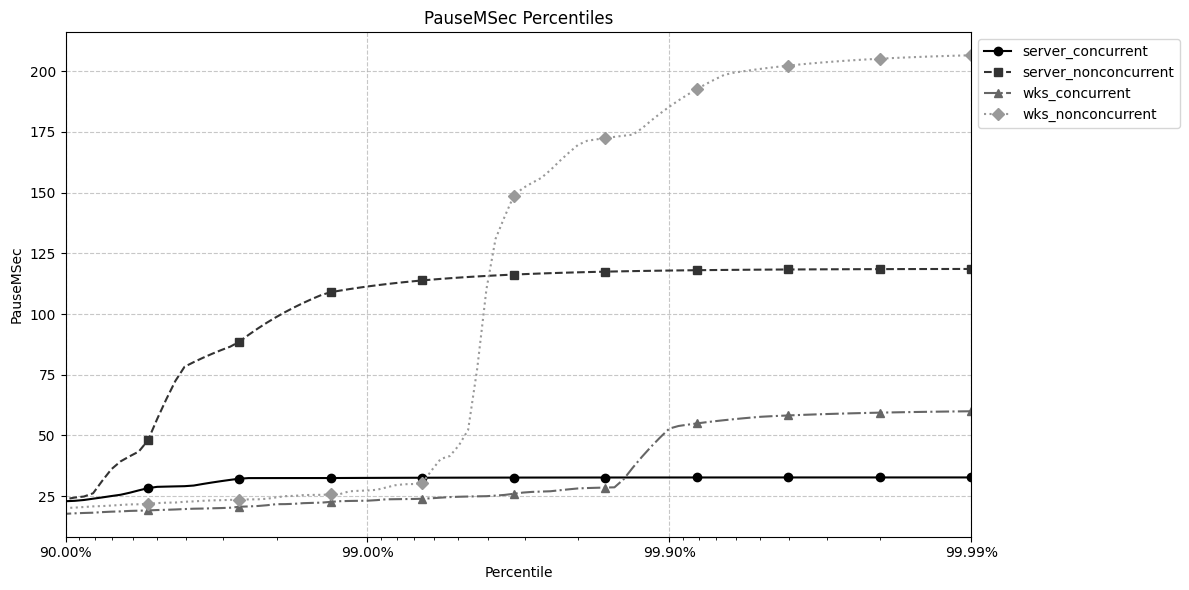

In [157]:
plot_gc_stats_percentiles(directory)

# Client

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

def plot_jmeter_elapsed_time(directory, trim_start=0, trim_end=0):
    def process_file(filepath):
        df = pd.read_csv(filepath)
        df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='ms')
        df = df.sort_values('timeStamp')
        df['relativeTime'] = (df['timeStamp'] - df['timeStamp'].min()).dt.total_seconds()
        filename = os.path.basename(filepath)
        series_name = filename.replace('nop_jmeter_', '').replace('.csv', '')
        return df, series_name

    processed_data = []
    for filename in os.listdir(directory):
        if filename.startswith('nop_jmeter_') and filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            processed_data.append(process_file(filepath))

    labels = set()
    for df, _ in processed_data:
        labels.update(df['label'].unique())

    colors = plt.cm.get_cmap('tab10')

    for label in labels:
        plt.figure(figsize=(12, 6))
        for i, (df, series_name) in enumerate(processed_data):
            label_data = df[df['label'] == label]

            # Trim data
            start_time = label_data['timeStamp'].min() + pd.Timedelta(seconds=trim_start)
            end_time = label_data['timeStamp'].max() - pd.Timedelta(seconds=trim_end)
            trimmed_data = label_data[(label_data['timeStamp'] >= start_time) &
                                      (label_data['timeStamp'] <= end_time)]

            plt.scatter(trimmed_data['relativeTime'], trimmed_data['elapsed'],
                        label=series_name, color=colors(i/len(processed_data)), alpha=0.7)
            plt.plot(trimmed_data['relativeTime'], trimmed_data['elapsed'],
                     color=colors(i/len(processed_data)), alpha=0.5)

        plt.xlabel('Relative Time (seconds)')
        plt.ylabel('Elapsed Time (ms)')
        plt.title(f'Elapsed Time for {label}\n(Trimmed: {trim_start}s start, {trim_end}s end)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import os

def plot_jmeter_elapsed_percentiles(directory, trim_start=0, trim_end=0):
    def process_file(filepath):
        df = pd.read_csv(filepath)
        df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='ms')
        df = df.sort_values('timeStamp')
        filename = os.path.basename(filepath)
        series_name = filename.replace('nop_jmeter_', '').replace('.csv', '')
        return df, series_name

    processed_data = []
    for filename in os.listdir(directory):
        if filename.startswith('nop_jmeter_') and filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            processed_data.append(process_file(filepath))

    labels = set()
    for df, _ in processed_data:
        labels.update(df['label'].unique())

    # Book-friendly grayscale line styles and markers
    styles = [
        {'color': '#000000', 'linestyle': '-', 'marker': 'o'},
        {'color': '#666666', 'linestyle': '--', 'marker': 's'},
        {'color': '#999999', 'linestyle': ':', 'marker': '^'},
        {'color': '#333333', 'linestyle': '-.', 'marker': 'D'},
        {'color': '#CCCCCC', 'linestyle': (0, (3, 1, 1, 1)), 'marker': 'v'},
    ]

    for label in labels:
        fig, ax = plt.subplots(figsize=(12, 6))
        for i, (df, series_name) in enumerate(processed_data):
            label_data = df[df['label'] == label]

            # Trim data
            start_time = label_data['timeStamp'].min() + pd.Timedelta(seconds=trim_start)
            end_time = label_data['timeStamp'].max() - pd.Timedelta(seconds=trim_end)
            trimmed_data = label_data[(label_data['timeStamp'] >= start_time) &
                                      (label_data['timeStamp'] <= end_time)]

            percentiles = 1 - 10**np.linspace(-4, -1, 100)
            elapsed_percentiles = np.percentile(trimmed_data['elapsed'], percentiles * 100)

            style = styles[i % len(styles)]
            ax.semilogx(1 - percentiles, elapsed_percentiles, label=series_name,
                        color=style['color'], linestyle=style['linestyle'],
                        marker=style['marker'], markevery=10, markersize=5, base=10)

        ax.set_xlim(1e-4, 1e-1)
        ax.invert_xaxis()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{(1-x):,.2%}'))
        ax.set_xlabel('Percentile')
        ax.set_ylabel('Elapsed Time (ms)')
        ax.set_title(f'Elapsed Time Percentiles for {label}\n(Trimmed: {trim_start}s start, {trim_end}s end)')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)

        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

        plt.tight_layout()
        plt.show()

def plot_jmeter_bar_with_stats(directory, trim_start=0, trim_end=0):
    def process_file(filepath):
        df = pd.read_csv(filepath)
        df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='ms')
        df = df.sort_values('timeStamp')
        filename = os.path.basename(filepath)
        series_name = filename.replace('nop_jmeter_', '').replace('.csv', '')
        return df, series_name

    processed_data = []
    for filename in os.listdir(directory):
        if filename.startswith('nop_jmeter_') and filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            processed_data.append(process_file(filepath))

    labels = sorted(set(label for df, _ in processed_data for label in df['label'].unique()))
    series_names = [name for _, name in processed_data]

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.8 / len(processed_data)
    index = np.arange(len(labels))

    # Book-friendly grayscale color scheme
    grays = ['#FFFFFF', '#CCCCCC', '#999999', '#666666', '#333333']
    patterns = ['', '//', '\\\\', 'xx', '..']

    for i, (df, series_name) in enumerate(processed_data):
        stats = []
        for label in labels:
            label_data = df[df['label'] == label]

            # Trim data
            start_time = label_data['timeStamp'].min() + pd.Timedelta(seconds=trim_start)
            end_time = label_data['timeStamp'].max() - pd.Timedelta(seconds=trim_end)
            trimmed_data = label_data[(label_data['timeStamp'] >= start_time) &
                                      (label_data['timeStamp'] <= end_time)]

            stats.append({
                'min': trimmed_data['elapsed'].min(),
                'max': trimmed_data['elapsed'].max(),
                'mean': trimmed_data['elapsed'].mean()
            })

        mins = [s['min'] for s in stats]
        maxs = [s['max'] for s in stats]
        means = [s['mean'] for s in stats]

        x = index + i * bar_width
        ax.bar(x, np.array(maxs) - np.array(mins), bar_width,
               bottom=mins, label=series_name, color=grays[i % len(grays)],
               edgecolor='black', hatch=patterns[i % len(patterns)], linewidth=1)

        # Plot mean as a horizontal line
        for j, mean in enumerate(means):
            ax.plot([x[j] - bar_width/2, x[j] + bar_width/2], [mean, mean], color='black', linewidth=2)

    ax.set_xlabel('Label')
    ax.set_ylabel('Elapsed Time (ms)')
    ax.set_title(f'Elapsed Time Statistics\n(Trimmed: {trim_start}s start, {trim_end}s end)')
    ax.set_xticks(index + bar_width * (len(processed_data) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')

    # Custom legend
    handles = [plt.Rectangle((0,0),1,1, facecolor=grays[i % len(grays)],
                             edgecolor='black', hatch=patterns[i % len(patterns)])
               for i in range(len(processed_data))]
    handles.append(Line2D([0], [0], color='black', linewidth=2))
    ax.legend(handles, series_names + ['Mean'], loc='upper left', bbox_to_anchor=(1, 1))

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

directory = '/content/drive/MyDrive/Colab Notebooks/benchmarks'

<ipython-input-131-75075fd76936>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


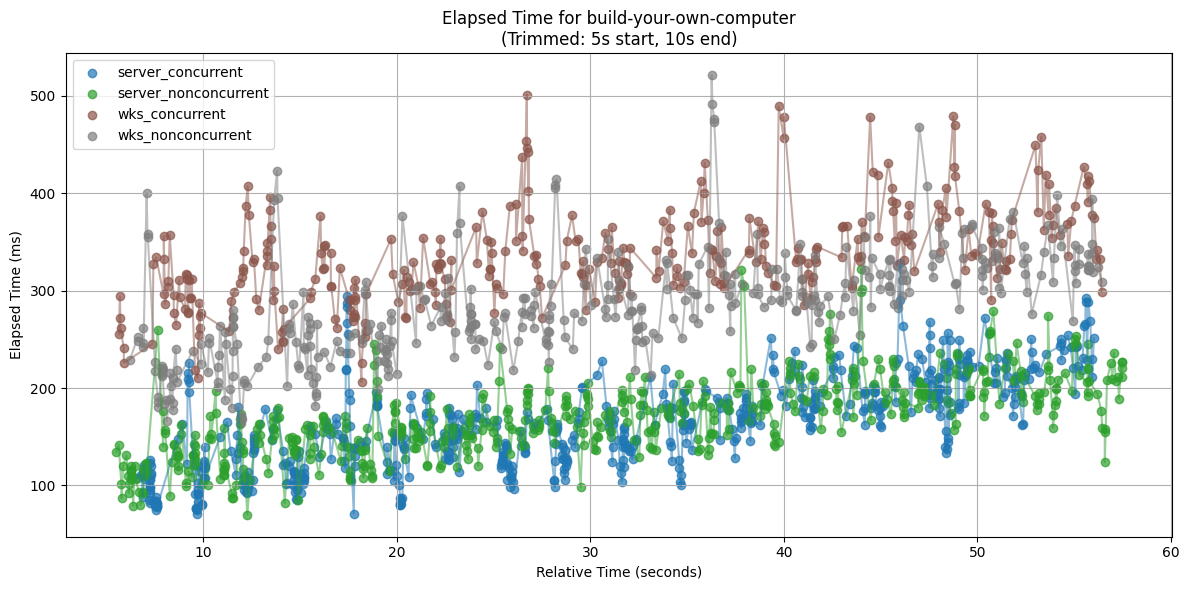

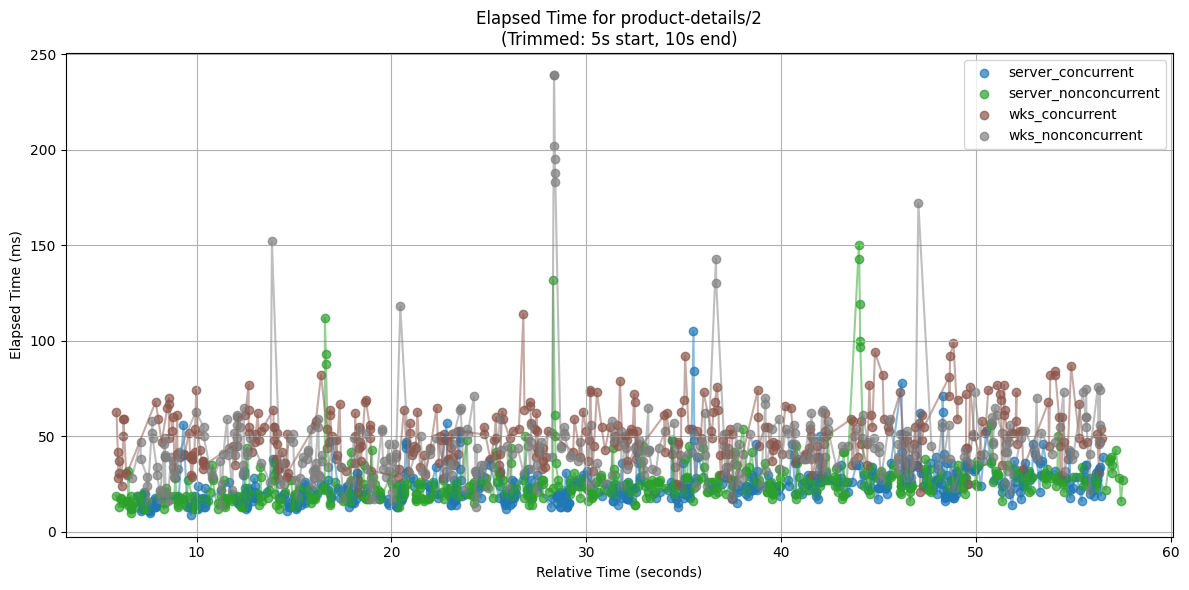

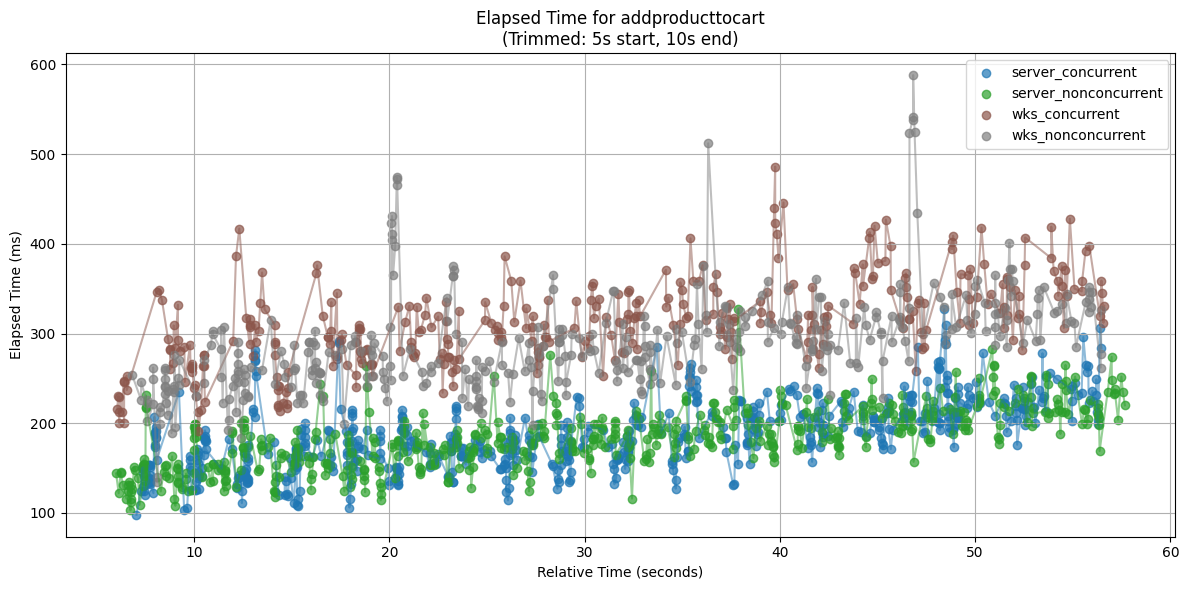

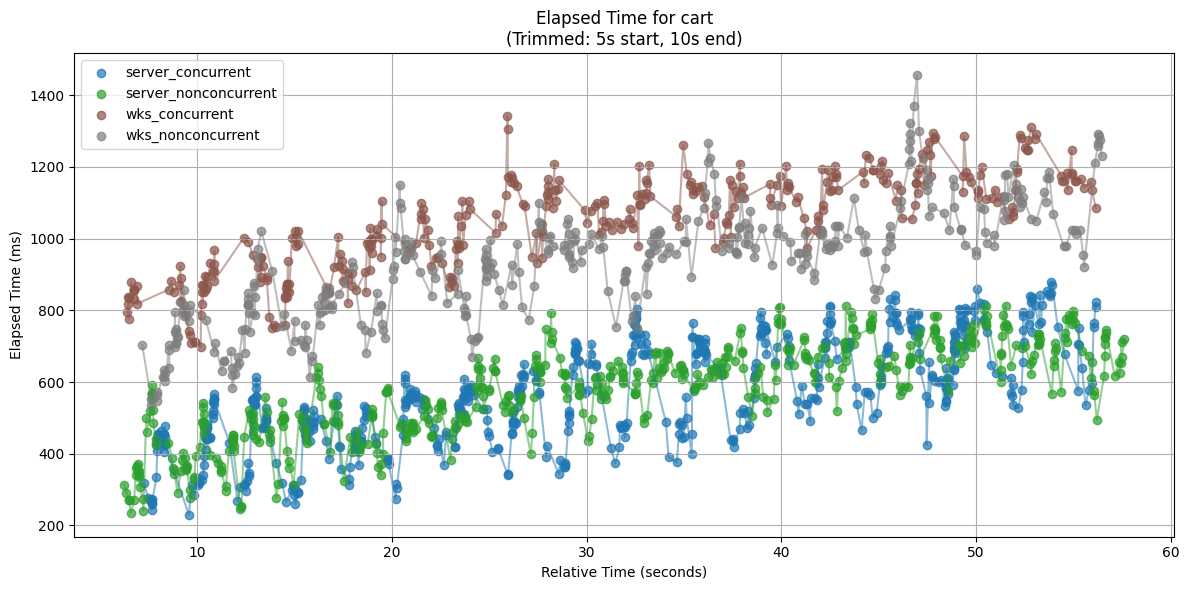

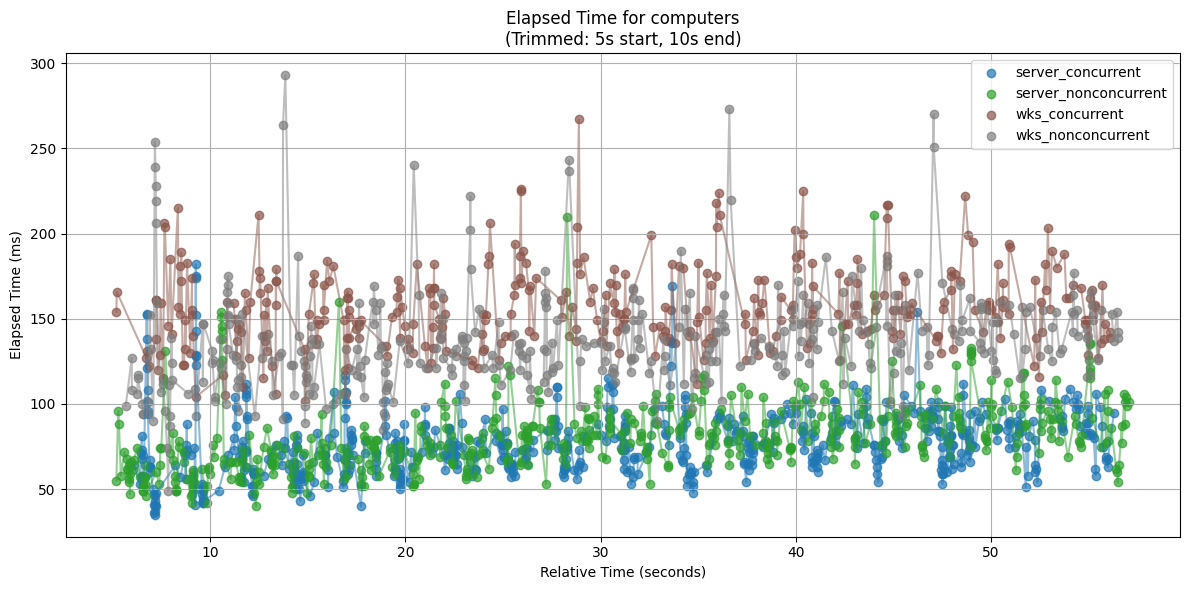

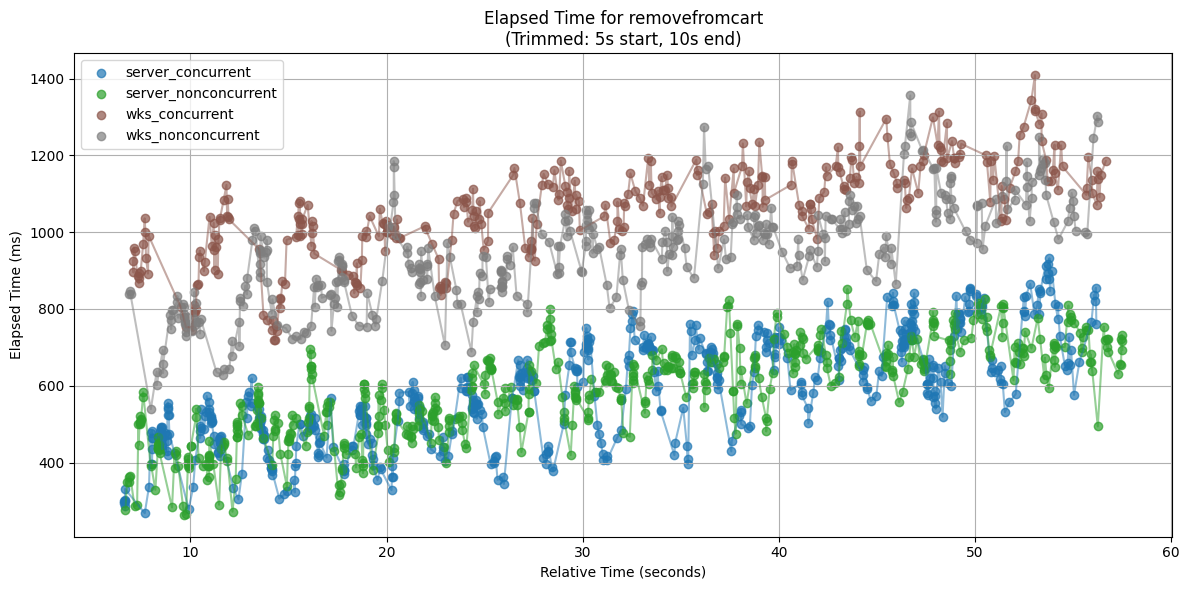

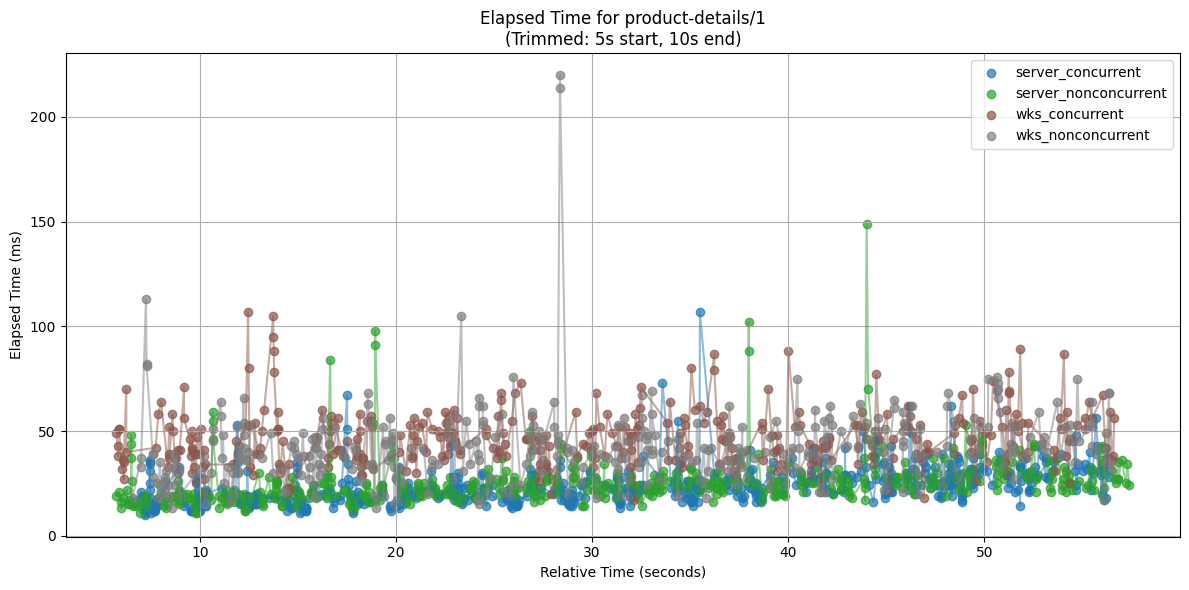

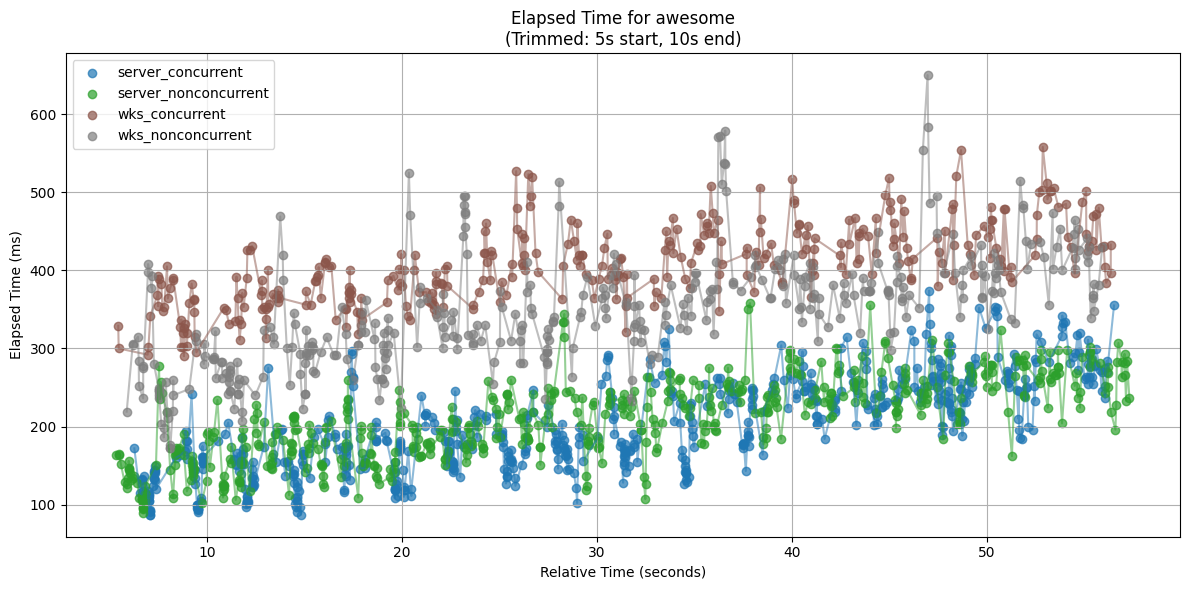

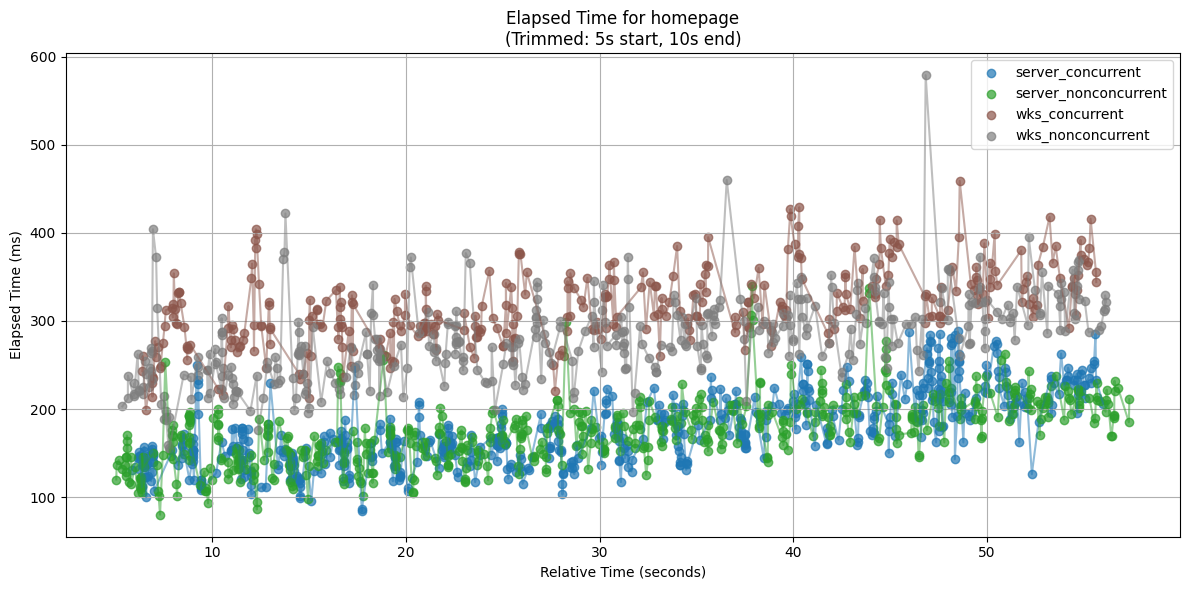

In [132]:
plot_jmeter_elapsed_time(directory, trim_start=5, trim_end=10)

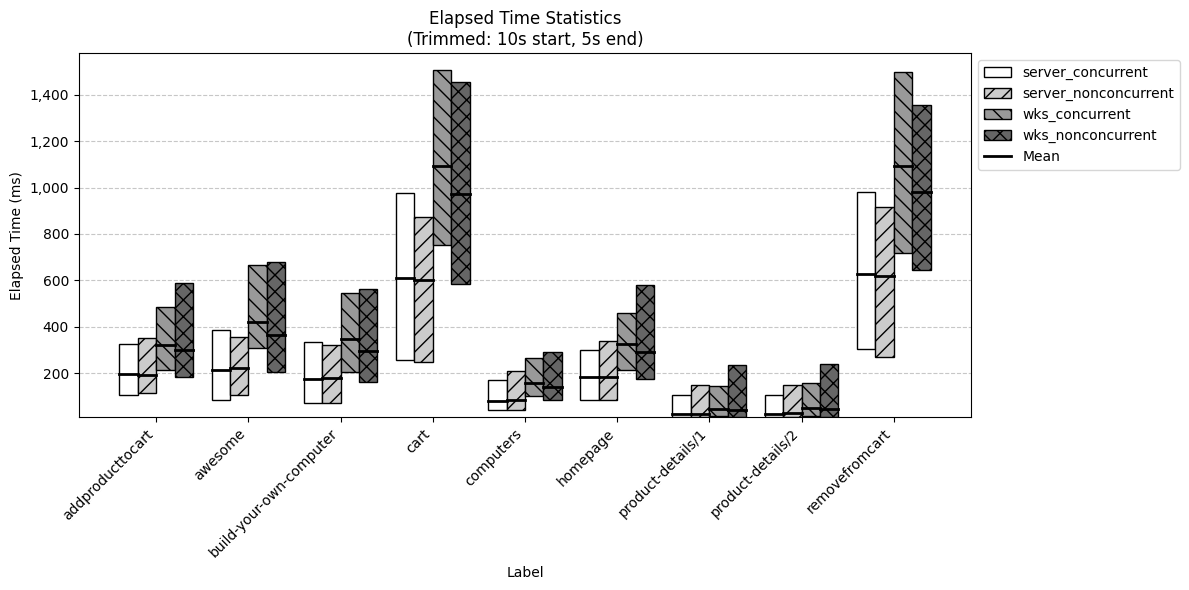

In [143]:
plot_jmeter_bar_with_stats(directory, trim_start=10, trim_end=5)

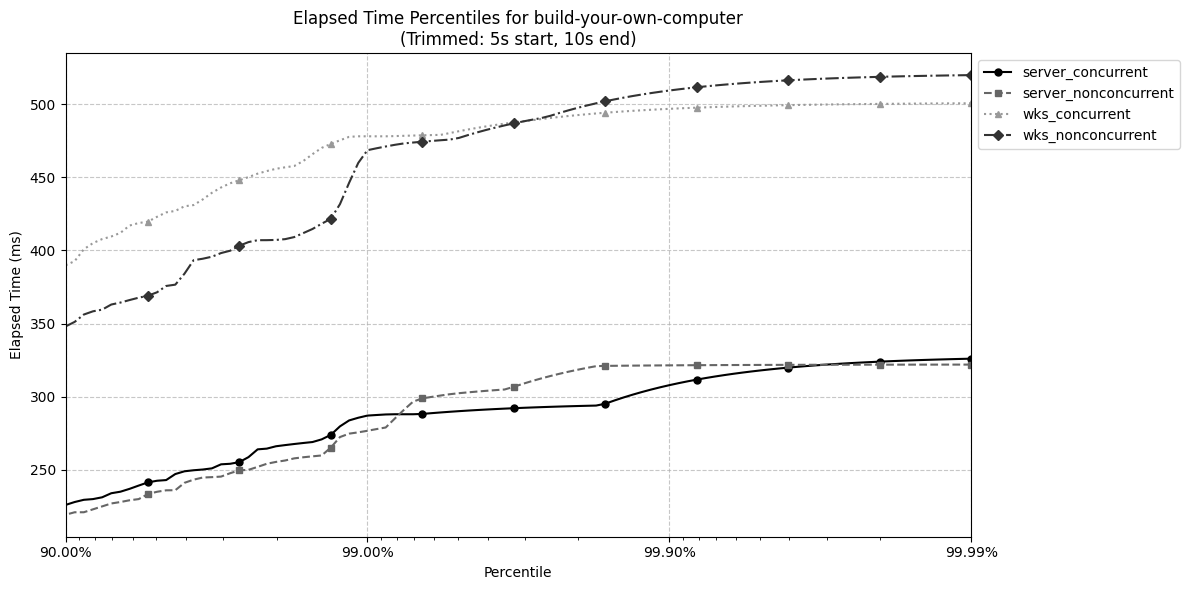

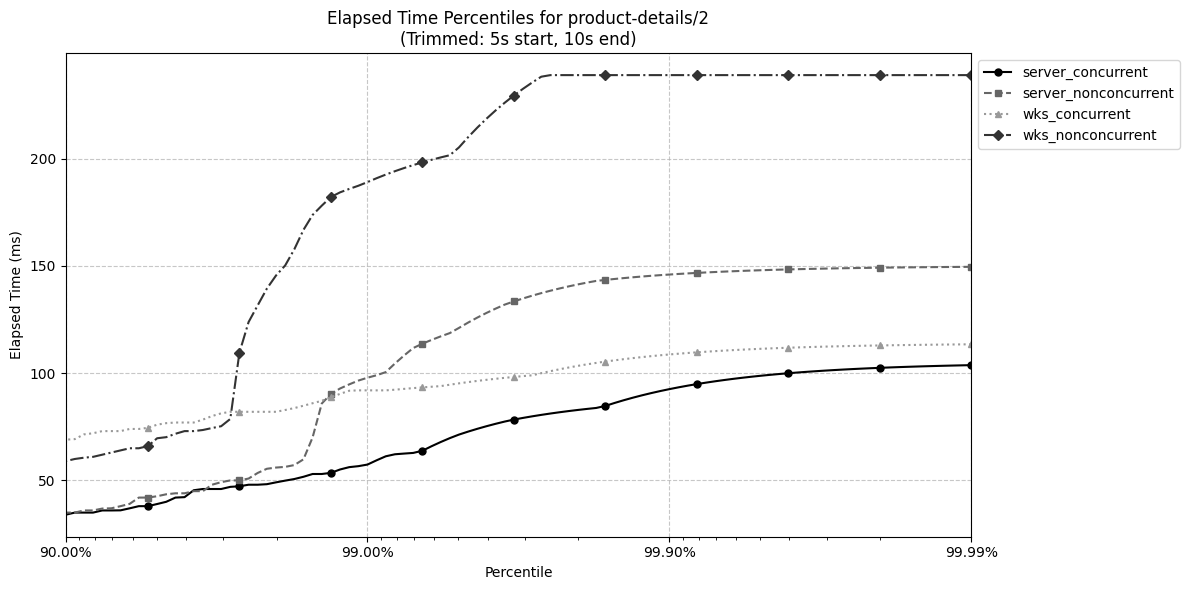

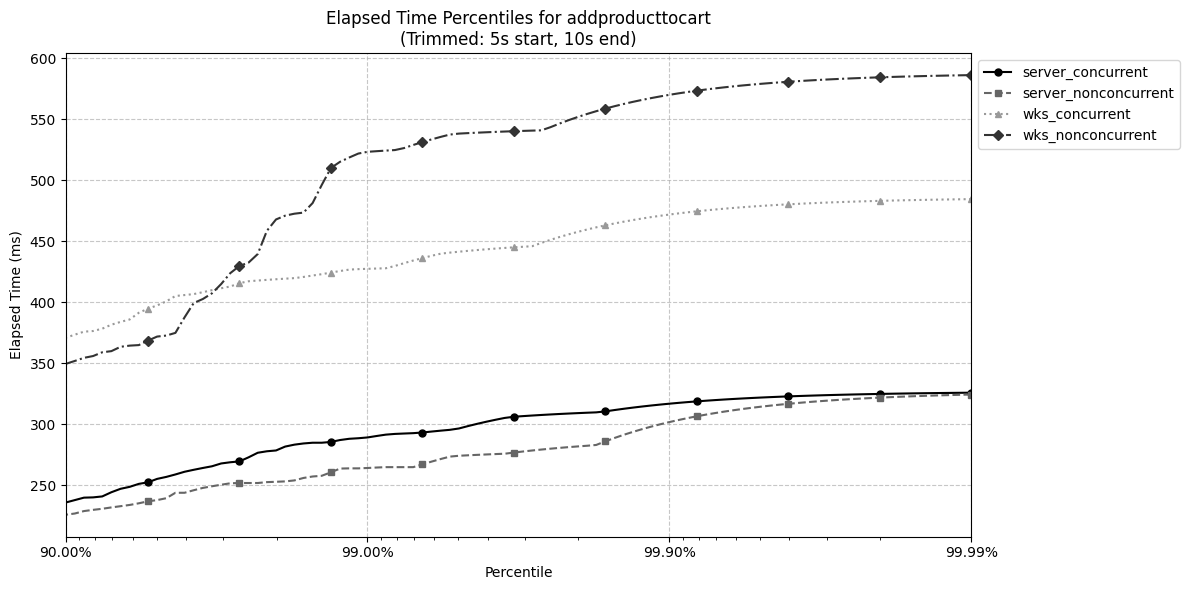

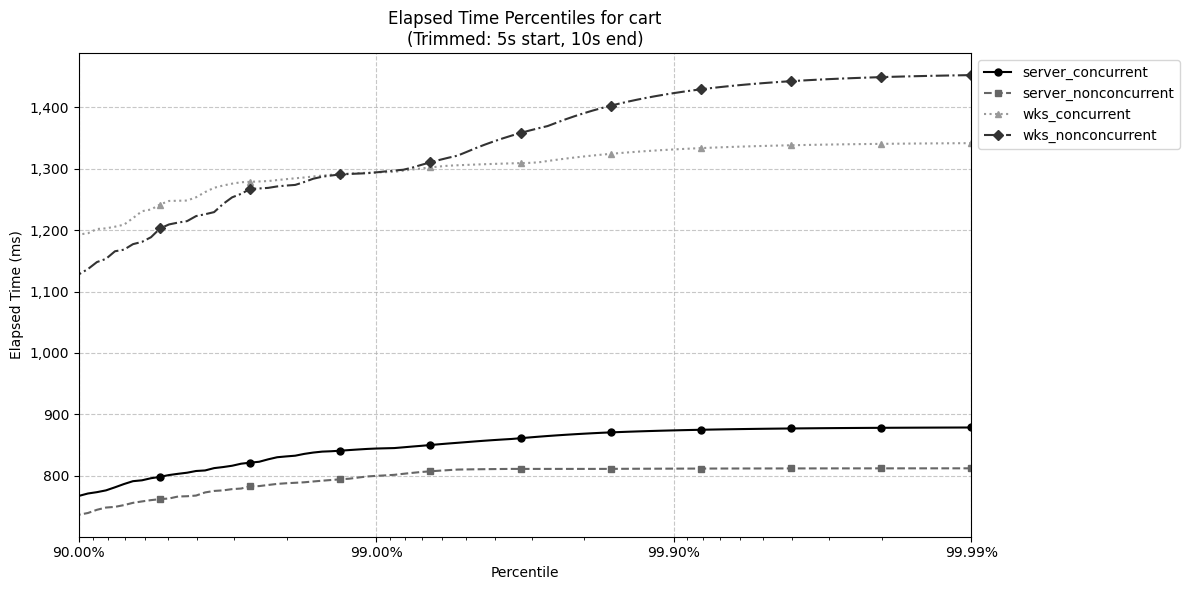

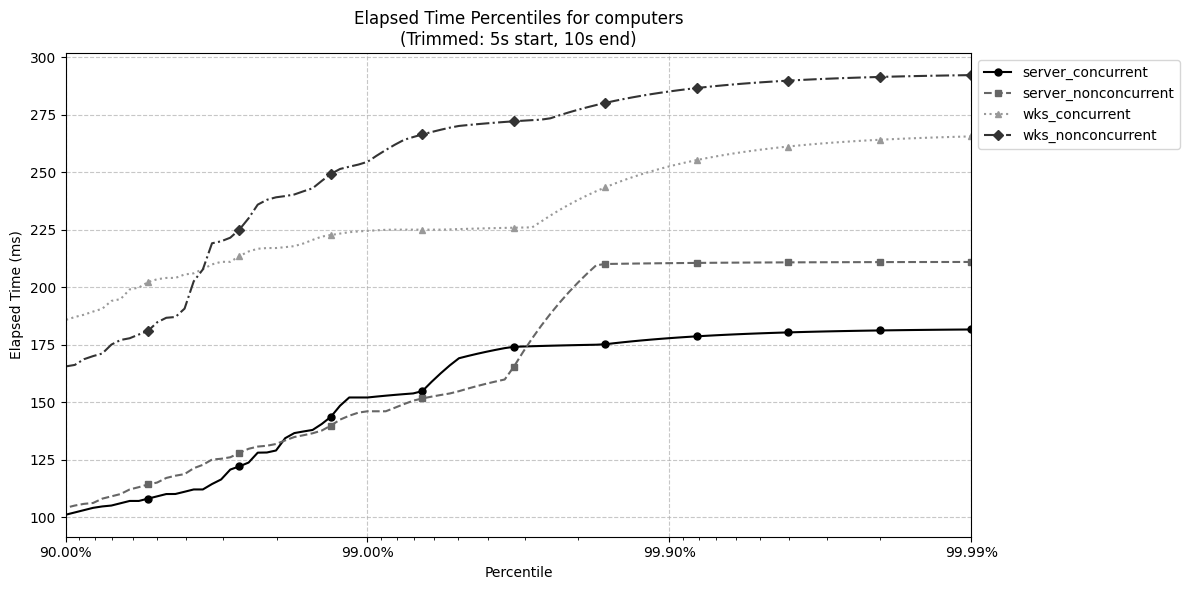

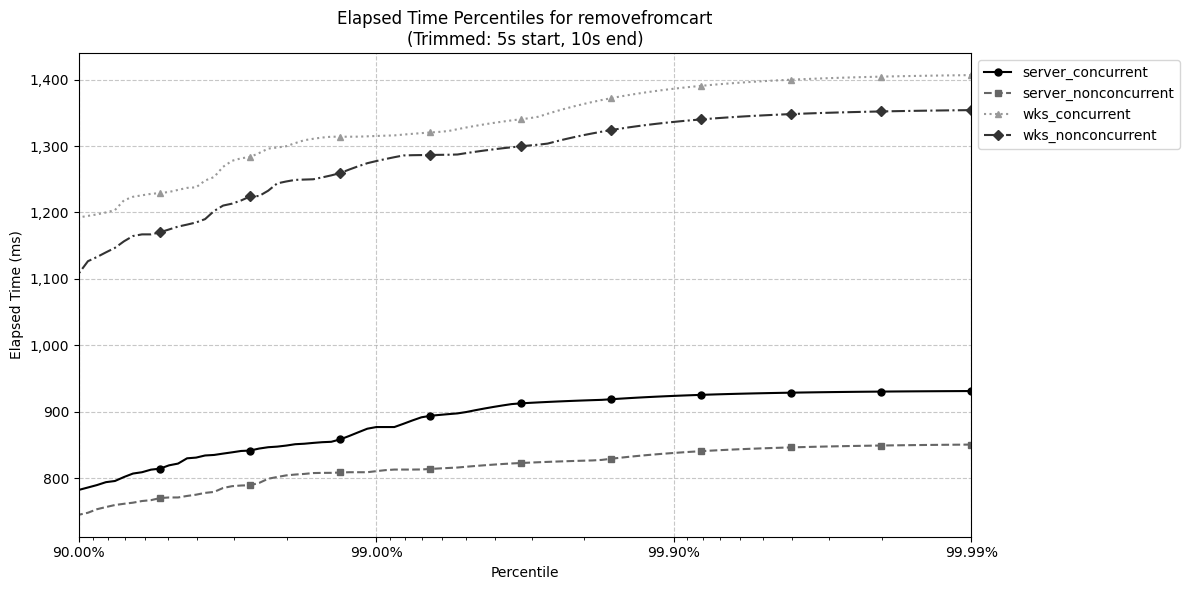

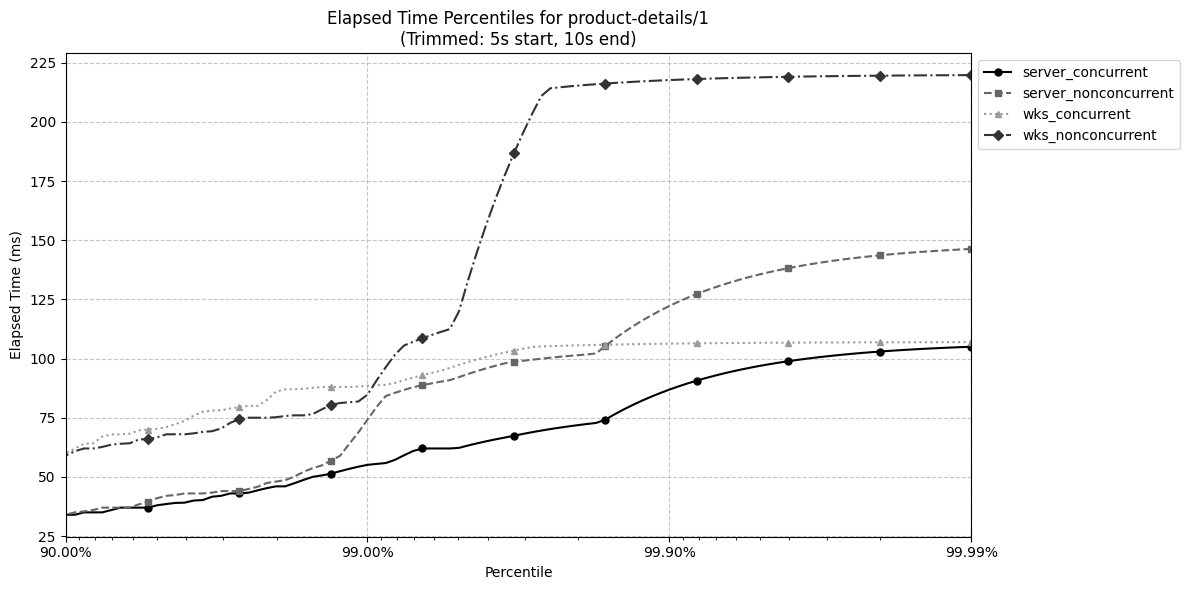

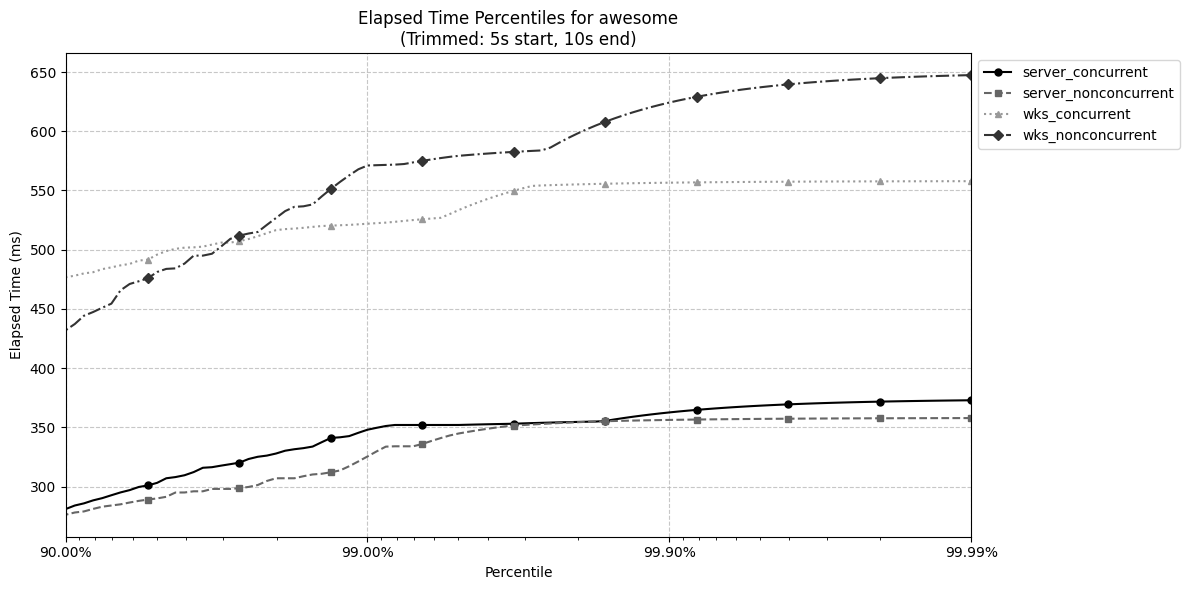

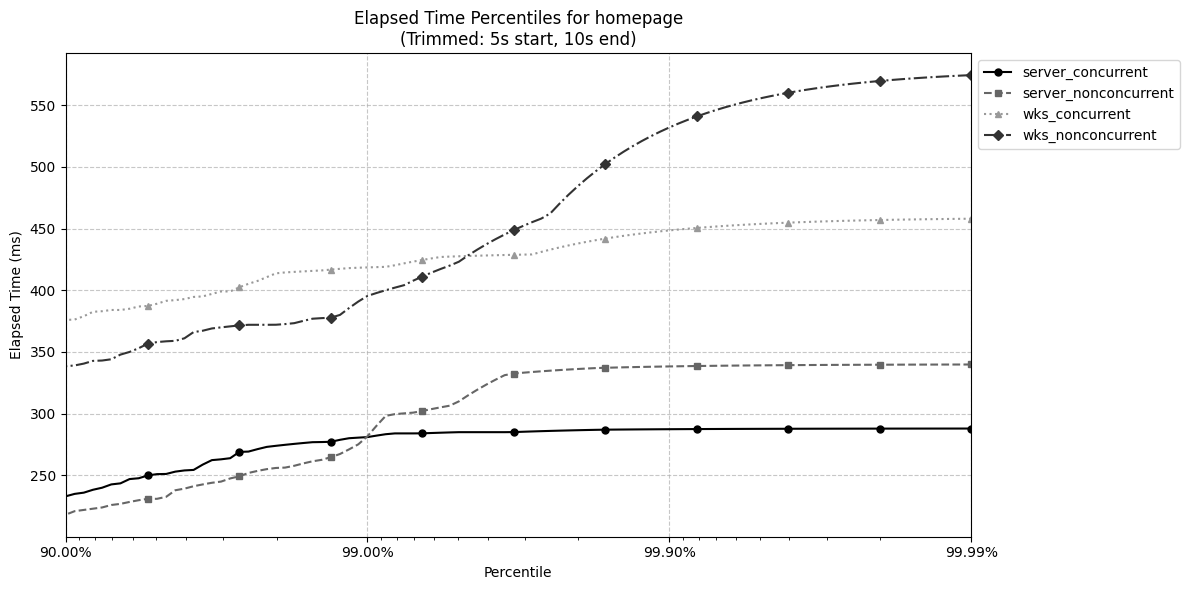

In [160]:
plot_jmeter_elapsed_percentiles(directory, trim_start=5, trim_end=10)